In [34]:
# Imports
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skspatial.objects import Line, Points, Plane

In [35]:
def open_line(file_name):
    '''
    Opens one of the text files and parses the line into a skspatial object
    '''
    
    with open(file_name) as f:
        lines = f.readlines()

    point = [float(dim) for dim in lines[0].split()[1:]]
    line = [float(dim) for dim in lines[1].split()[1:]]
    
    return Line(point, line)

In [36]:
def open_carbon_atoms(file_name):    

    with open(file_name) as pdb_structure:
        lines = pdb_structure.readlines()

    allCA_7EJ1 = list()

    for line in lines:
        line = line[:22] + ' ' + line[22:] # correct .pdb stupidity        

        if len(line.split()) > 5:
            residue_num = int(line.split()[5])
            chain = line.split()[4]
        else:
            continue

        if 'CA' in line:
            x = float(line.split()[6])
            y = float(line.split()[7])
            z = float(line.split()[8])
            data = [x,y,z]
            allCA_7EJ1.append(data)   

    return np.array(allCA_7EJ1)

In [37]:
# Important hyperparameters!!

file_name = "7EJ1"
channel_type = "KCN"

# This is the parameter that determines how far apart the orthogonal planes are from each other.
distance_between_planes = 10

# This is the parameter that determines the radius from the middle line that is used to check 
# for atoms to use for calculations for measurement of channel radius.
radius_to_check_for_atoms = 20

In [38]:
# Open line and carbon atoms for 6V01

# Show Mark problem with 6V01
line = open_line(f"line_{file_name}.txt")
points = open_carbon_atoms(f"../DATA/ALIGNED/{channel_type}/{file_name}.pdb")

In [159]:
# Generate planes

origin = [0, 0, 0]
origin_projection = line.project_point(origin)
perpendicular_line = Line(origin_projection, origin - origin_projection)
normal_vector = perpendicular_line.vector.cross(line.vector)
first_plane = Plane(origin_projection, normal_vector)
second_plane = Plane(origin_projection, line.vector.cross(normal_vector))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  after removing the cwd from sys.path.


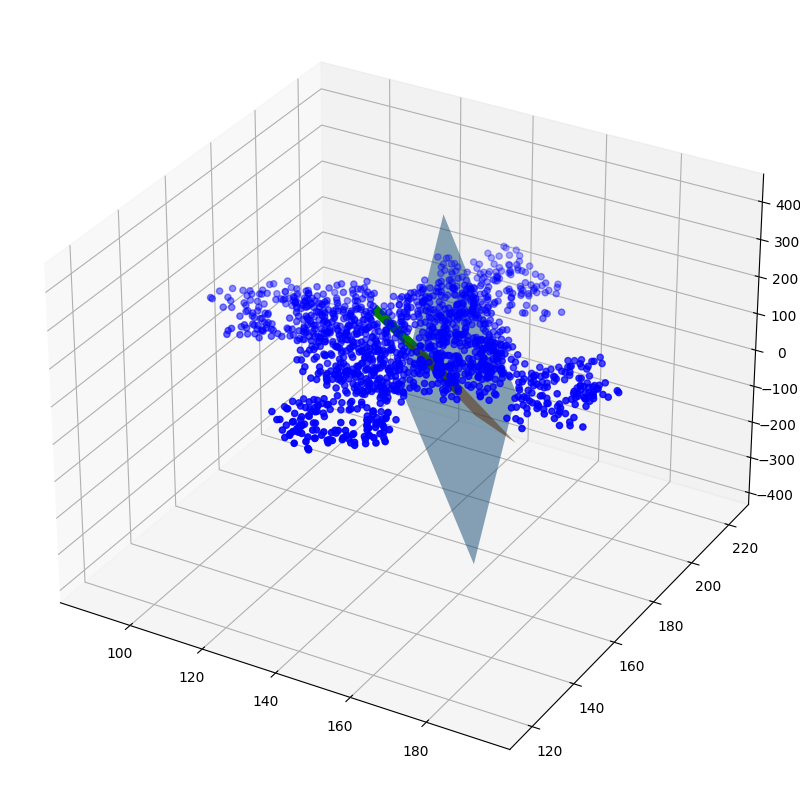

In [160]:
# View results

fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)

line.plot_3d(ax, -100, 100, linewidth = 7, c = 'g')
first_plane.plot_3d(ax, lims_x = (-10, 10), lims_y = (-10, 10), alpha = 0.5)
second_plane.plot_3d(ax, lims_x = (-10, 10), lims_y = (-10, 10), alpha = 0.5)
ax.scatter(points[:,0], points[:,1], points[:,2], c = 'b', marker = 'o')
ax.scatter(line.point[0], line.point[1], line.point[2], c = 'y', marker = 'o')
ax.set_label(['x','y','z'])
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  import sys


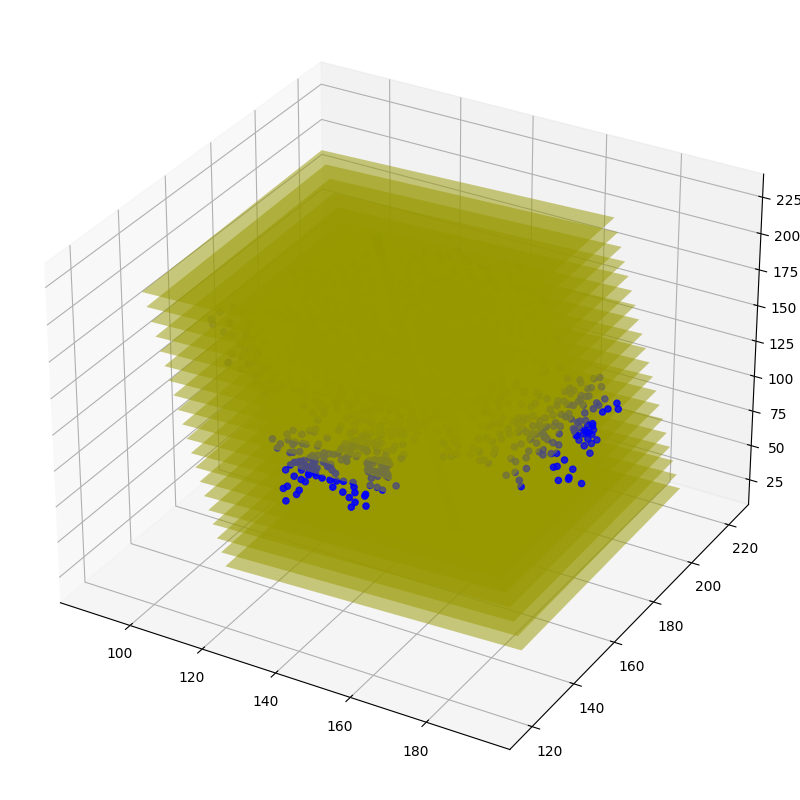

In [161]:
# Separate the line/channel into arbitrary size length. Create orthogonal planes to the two perpendicular planes.

plane_points = np.array([line.point + line.vector * i for i in range(-100, 100, distance_between_planes)])
orthogonal_planes = np.array([Plane(plane_points[i], line.vector) for i in range(plane_points.shape[0])])

fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)

line.plot_3d(ax, -100, 100, linewidth = 7, c = 'g')
ax.scatter(points[:,0], points[:,1], points[:,2], c = 'b', marker = 'o')

for plane in orthogonal_planes:
    plane.plot_3d(ax, lims_x = (-40, 40), lims_y = (-40, 40), color = 'y', alpha = 0.5)

ax.set_label(['x','y','z'])
plt.show()

In [42]:
# Determine what quadrant carbon atoms are in

quadrants = np.ndarray((orthogonal_planes.shape[0] - 1, 4), object)

for i in range(orthogonal_planes.shape[0] - 1):
    quadrant_1, quadrant_2, quadrant_3, quadrant_4 = [], [], [], []
    
    for atom in points:
        if orthogonal_planes[i].side_point(atom) > 0 and orthogonal_planes[i + 1].side_point(atom) < 0:
            if line.distance_point(atom) < radius_to_check_for_atoms:
                if first_plane.side_point(atom) < 0 and second_plane.side_point(atom) > 0:
                    quadrant_1.append(atom)                    
                elif first_plane.side_point(atom) > 0 and second_plane.side_point(atom) > 0:
                    quadrant_2.append(atom)                    
                elif first_plane.side_point(atom) > 0 and second_plane.side_point(atom) < 0:
                    quadrant_3.append(atom)                    
                elif first_plane.side_point(atom) < 0 and second_plane.side_point(atom) < 0:
                    quadrant_4.append(atom)
    
    quadrants[i][0] = quadrant_1
    quadrants[i][1] = quadrant_2
    quadrants[i][2] = quadrant_3
    quadrants[i][3] = quadrant_4

print("Number of points per quadrant:")
print("N.B. shape = (number of planes x number of quadrants)")
for plane in quadrants:
    print([len(plane[i]) for i in range(4)])

Number of points per quadrant:
N.B. shape = (number of planes x number of quadrants)
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[2, 2, 2, 2]
[12, 12, 12, 12]
[20, 20, 20, 20]
[18, 18, 18, 18]
[17, 17, 17, 17]
[12, 12, 12, 12]
[3, 3, 3, 3]
[14, 14, 14, 14]
[14, 14, 14, 14]
[18, 18, 18, 18]
[8, 8, 8, 8]
[0, 0, 0, 0]
[0, 0, 0, 0]


In [43]:
# For each line segment,
# For each quadrant, find the atom closest to the line. 
# Using the four atoms identified, calculate the channel's average radius length, maximum radius length, and minimum radius length.
radii = []
for segment in quadrants:

    avg_radius = 0
    for quadrant in segment:
        if len(quadrant) < 1:
            continue

        smallest_radius = np.min([line.distance_point(atom) for atom in quadrant])
        avg_radius += smallest_radius

    avg_radius = avg_radius / 4
    radii.append(avg_radius)

# These are features from the channel
max_radius = np.max([value for value in radii if value > 0])
min_radius = np.min([value for value in radii if value > 0])
avg_radius = np.mean([value for value in radii if value > 0])

print(("Max radius", "Min radius", "Avg radius"))
print(max_radius, min_radius, avg_radius)


('Max radius', 'Min radius', 'Avg radius')
16.763209651707243 3.9870895312832295 8.538582269782738


A value of zero indicates no points were found in that plane's quadrants


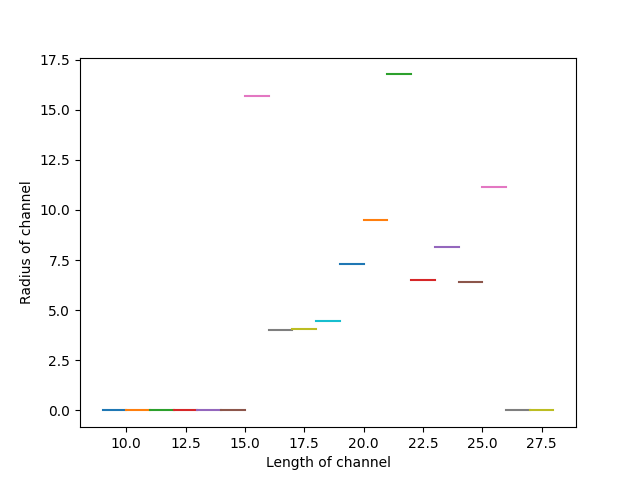

In [44]:
fig, ax = plt.subplots()

distance_between_planes = int(orthogonal_planes[0].point.distance_point(orthogonal_planes[-1].point) / orthogonal_planes.shape[0])

for i in range(len(radii)):
    ax.plot((i + distance_between_planes, (i + 1) + distance_between_planes), (radii[i], radii[i]))

print("A value of zero indicates no points were found in that plane's quadrants")
ax.set_xlabel("Length of channel")
ax.set_ylabel("Radius of channel")
plt.show()